# <center>**Computer Vision Project**</center>
## <center><i>**Skin Cancer Detection**</i></center>
---
### <center>Submitted by:<center>
###<center>1. Mutahhar bin Muzaffar<br>&nbsp; &nbsp;&nbsp;FA17-BCS-058</center>
###<center>2. Sher Alam<br>&nbsp; &nbsp;&nbsp;FA17-BCS-082</center>

# Importing Libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import keras
from keras.utils.np_utils import to_categorical
from keras.layers import Conv2D,MaxPooling2D,Dense,BatchNormalization,ZeroPadding2D,Flatten,Input,Dropout,Activation,UpSampling2D,GlobalMaxPooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt



Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Preprocessing Data

We loaded the dataset from our google drive as this file was quite big in size. The dataset we loaded consists of 28x28x3=2352+1 columns  and 10,000 rows. Each row represents a sample from the dataset whereas each column represents a specific pixel value. The last column represent the label encoding for each sample respectively. The dataset consists of label encoding for 7 types of cancer namely `Actinic Keratose`,`Basal Cell Carcinoma`,`enign Keratosis-like Lesion`,`Dermatofibroma`,`Melanocytic Nevi`,`Vascular Lesion`,`Melonoma`.

In [4]:
data=pd.read_csv('/content/drive/My Drive/Datasets/MINIST HAM 10000/hmnist_28_28_RGB.csv',engine='python')
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,pixel0010,pixel0011,pixel0012,pixel0013,pixel0014,pixel0015,pixel0016,pixel0017,pixel0018,pixel0019,pixel0020,pixel0021,pixel0022,pixel0023,pixel0024,pixel0025,pixel0026,pixel0027,pixel0028,pixel0029,pixel0030,pixel0031,pixel0032,pixel0033,pixel0034,pixel0035,pixel0036,pixel0037,pixel0038,pixel0039,...,pixel2313,pixel2314,pixel2315,pixel2316,pixel2317,pixel2318,pixel2319,pixel2320,pixel2321,pixel2322,pixel2323,pixel2324,pixel2325,pixel2326,pixel2327,pixel2328,pixel2329,pixel2330,pixel2331,pixel2332,pixel2333,pixel2334,pixel2335,pixel2336,pixel2337,pixel2338,pixel2339,pixel2340,pixel2341,pixel2342,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,162,192,208,165,201,209,165,205,208,165,194,212,169,198,216,181,204,216,178,204,215,172,205,217,173,209,217,166,202,214,...,216,181,212,215,176,208,213,168,191,209,159,184,212,168,194,212,172,198,208,173,193,203,168,183,190,142,152,177,123,134,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,128,158,172,136,162,175,134,157,177,126,158,186,138,163,197,153,187,198,153,186,203,168,206,205,169,204,207,164,199,205,...,209,176,203,207,171,191,208,172,197,205,169,188,198,159,172,200,159,192,191,140,182,177,128,141,147,101,97,113,79,82,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,149,165,207,149,159,209,156,164,202,136,130,200,133,129,208,146,157,212,159,167,214,157,168,211,143,150,215,148,169,213,...,221,168,175,222,170,188,221,167,184,203,144,155,201,146,155,210,163,177,190,142,152,192,152,172,194,153,176,178,134,149,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,125,134,177,118,123,190,137,146,192,127,143,200,141,162,207,156,170,202,144,151,202,138,155,212,159,177,211,155,172,211,...,181,137,145,189,147,166,192,157,185,169,129,144,148,114,122,157,125,137,157,127,147,154,128,147,130,102,114,87,63,73,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,179,214,232,189,222,235,193,219,234,191,206,238,200,219,244,213,240,243,213,239,242,210,238,244,216,241,247,224,244,246,...,238,195,209,237,191,200,238,194,201,239,197,216,238,195,219,232,179,201,217,150,173,224,171,207,227,177,206,222,178,201,209,166,185,172,135,149,109,78,92,2


To avoid in consistent results, we have to check whether our dataset contains any missing or infinite values. Luckily, as you can see, our dataset doesn't contain any sort of missing or infinite values.

In [5]:
data.replace(to_replace=[np.inf,-np.inf],value=np.nan,inplace=True)
data.dropna(inplace=True)
print("Dataframe shape after dropping na/inf: {}".format(data.shape))
print("Does dataframe still have inf values: {}".format(np.any(np.isinf(data))))
print("Does dataframe still have nan values: {}".format(np.any(np.isnan(data))))

Dataframe shape after dropping na/inf: (10015, 2353)
Does dataframe still have inf values: False
Does dataframe still have nan values: False


The dataset contains a column 'Labels' having numeric code like 0,1,2 i.e. Label Encoding. To display the total counts of sample per cancer class, we have to remove label encoding by placing the subsequent dictionaries.

In [6]:
 labels_dict={
    0:'akiec',
    1:'bcc',
    2:'bkl',
    3:'df',
    4:"nv",
    5:'vasc',
    6:'mel',
}
lesion_type_dict={
        'akiec':'Actinic Keratose',
        'bcc':'Basal Cell Carcinoma',
        'bkl':'Benign Keratosis-like Lesion',
        'df':'Dermatofibroma',
        'nv':'Melanocytic Nevi',
        'vasc':'Vascular Lesion',
        'mel':'Melonoma'
}
stats_df = pd.DataFrame({'Labels':data.label})
stats_df['Label_Codes'] = stats_df.Labels.map(labels_dict.get)
stats_df['Labels_Names'] = stats_df.Label_Codes.map(lesion_type_dict.get)
stats_df.head()

,Labels,Label_Codes,Labels_Names
0,2,bkl,Benign Keratosis-like Lesion
1,2,bkl,Benign Keratosis-like Lesion
2,2,bkl,Benign Keratosis-like Lesion
3,2,bkl,Benign Keratosis-like Lesion
4,2,bkl,Benign Keratosis-like Lesion


As you can see below, we have the highest count of samples for `Melanocytic Nevi`.

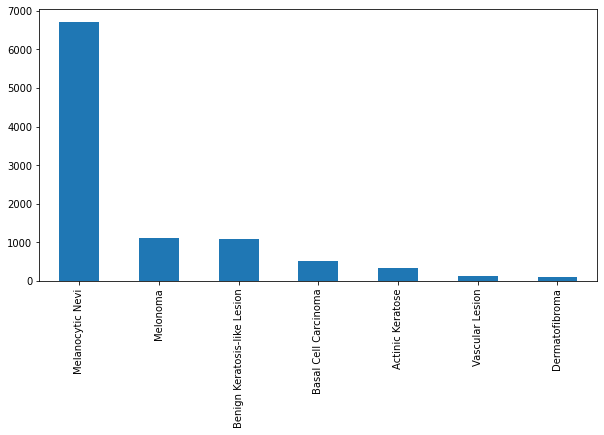

In [7]:
_, ax = plt.subplots(1,1,figsize=(10,5))
stats_df['Labels_Names'].value_counts().plot(kind='bar',ax=ax)

Now we will preprocess our data and prepare it to divide into train and test set.

In [8]:
X=data.drop("label", axis=1).values
Y=data.label
X.shape,Y.shape

((10015, 2352), (10015,))

In [9]:
X=X/255
X=X.reshape(-1,28,28,3)
X.shape

(10015, 28, 28, 3)

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1,random_state=0)
X_train.shape,Y_train.shape,X_test.shape,Y_test.shape

((9013, 28, 28, 3), (9013,), (1002, 28, 28, 3), (1002,))

In [11]:
Y_train=to_categorical(Y_train)
Y_test=to_categorical(Y_test)
Y_train.shape,Y_test.shape

((9013, 7), (1002, 7))

# Building and Training CNN

We decided to train 2 models for our project.
1. CNN Model from Scratch
2. VGG16 using transfer learning.

`CNN` is trained by Sher Alam whereas `VGG16` is retrained by Mutahhar bin Muzaffar.

As you can see, we made a custom architecture for our CNN. We added a BatchNormalization layer to normalize the output of each layer i.e. Normalize `z` in order to improve the performance of our model slightly. 

In [12]:
def cancer_detector(input_shape=(28,28,3)):
  X_input=Input(shape=input_shape)
  X=ZeroPadding2D(3)(X_input)
  X=Conv2D(32,3,padding='same')(X)
  X=BatchNormalization()(X)
  X=Activation('relu')(X)
  X=Dropout(0.3)(X)
  X=Conv2D(64,3,padding='same')(X)
  X=BatchNormalization()(X)
  X=Activation('relu')(X)
  X=Conv2D(64,3,padding='same')(X)
  X=BatchNormalization()(X)
  X=Activation('relu')(X)
  X=MaxPooling2D(2)(X)
  X=Conv2D(128,3,padding='same')(X)
  X=BatchNormalization()(X)
  X=Activation('relu')(X) 
  X=MaxPooling2D(2)(X)
  X=Dropout(0.2)(X) 
  X=Flatten()(X)
  X=Dense(128,activation='relu')(X)
  X=Dense(7,activation='softmax')(X)

  model=Model(inputs=X_input,outputs=X)
  return model

model= cancer_detector()
model.summary()



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 3)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 34, 34, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 34, 34, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 34, 34, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 34, 34, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        1849

In [13]:
adam=Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy'])

Due to the limited size of the dataset i.e. 10,000 samples, which is quite less for training a deep learning model, we used `ImageDataGenerator` to use data augmentation approache while training our models.

In [14]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [15]:
history = model.fit_generator(datagen.flow(X_train,Y_train,batch_size=64),steps_per_epoch=X_train.shape[0]//64,epochs=50,validation_data=(X_test,Y_test),verbose=1)

Epoch 1/50
140/140 [==============================] - 18s 126ms/step - loss: 1.4363 - accuracy: 0.6364 - val_loss: 1.5177 - val_accuracy: 0.1078
Epoch 2/50
140/140 [==============================] - 10s 74ms/step - loss: 0.8656 - accuracy: 0.6862 - val_loss: 1.6742 - val_accuracy: 0.1248
Epoch 3/50
140/140 [==============================] - 10s 74ms/step - loss: 0.8462 - accuracy: 0.6837 - val_loss: 1.0384 - val_accuracy: 0.5589
Epoch 4/50
140/140 [==============================] - 10s 74ms/step - loss: 0.7906 - accuracy: 0.7081 - val_loss: 0.8549 - val_accuracy: 0.6677
Epoch 5/50
140/140 [==============================] - 10s 74ms/step - loss: 0.7695 - accuracy: 0.7106 - val_loss: 0.8001 - val_accuracy: 0.7036
Epoch 6/50
140/140 [==============================] - 10s 74ms/step - loss: 0.7498 - accuracy: 0.7232 - val_loss: 0.9838 - val_accuracy: 0.5798
Epoch 7/50
140/140 [==============================] - 10s 73ms/step - loss: 0.7382 - accuracy: 0.7276 - val_loss: 0.8900 - val_accuracy

In [16]:
lossCNN,scoreCNN = model.evaluate(X_test,Y_test)

print("Loss for CNN is: {}\Accuracy for CNN is: {}".format(lossCNN,scoreCNN))

1002/1002 [==============================] - 1s 530us/step
Loss for CNN is: 0.7131723592024364\Accuracy for CNN is: 0.7475050091743469


As you can see above, due to the lack of sufficient dataset and even after using the data augmentation approch, our model still performed average with an accuracy of around 75%.

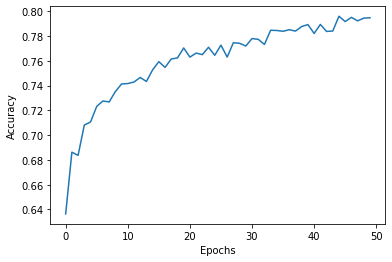

In [17]:
plt.plot(history.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

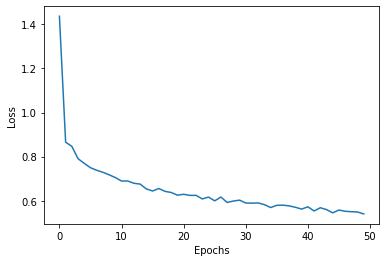

In [18]:
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [19]:
accuracy = []
accuracy.append({'CNN':scoreCNN})
model.save('./modelCNN.h5')

# Transfer Learning using VGG16

VGG16 is trained by Mutahhar bin Muzaffar using transfer learning. Our dataset consists of images of shape 28x28 whereas, vgg requires input of much greater size than this. That is why we had to use UpSampling layer of keras to produce an input which is acceptable by VGG16.
As you can see, we used the output of the last layer of vgg model i.e. `block5_pool` as the input of our additional 3 Dense layers used for classification of different types of cancer.

In [20]:
def vgg(input_shape):
  x_input=Input(shape=input_shape)
  x=UpSampling2D((2,2))(x_input)
  vgg=VGG16(input_tensor=x, include_top=False, weights="imagenet")
  x = GlobalMaxPooling2D()(vgg.get_layer('block5_pool').output)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.5)(x)
  x = Dense(7, activation='softmax')(x)
  model=Model(x_input,x)
  return model


In [21]:
model_vgg=vgg(input_shape=(28,28,3))

58892288/58889256 [==============================] - 6s 0us/step


In [22]:
model_vgg.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 3)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 56, 56, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 56, 56, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 56, 56, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 28, 28, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 28, 28, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 28, 28, 128)       1475

Here I have set all the layers of vgg except the last 3 dense layers to trainable so that I can train the weights of the last 3 layers to some extent.

In [23]:
for layers in model_vgg.layers:
  layers.trainable=False
for layers in model_vgg.layers[-3:]:
   layers.trainable=True

In [24]:
model_vgg.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 3)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 56, 56, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 56, 56, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 56, 56, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 28, 28, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 28, 28, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 28, 28, 128)       1475

In [25]:
adam=Adam(learning_rate=0.0001)
model_vgg.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy'])
model_vgg.fit_generator(datagen.flow(X_train,Y_train,batch_size=64),X_train.shape[0]//64,3,verbose=1)

Epoch 1/3
140/140 [==============================] - 9s 67ms/step - loss: 1.2470 - accuracy: 0.6290
Epoch 2/3
140/140 [==============================] - 8s 60ms/step - loss: 1.0719 - accuracy: 0.6689
Epoch 3/3
140/140 [==============================] - 9s 62ms/step - loss: 1.0310 - accuracy: 0.6691


Now we're training the entirely VGG model on our data for a few epochs in order for the model to fit our data accordingly.

In [33]:
for layers in model_vgg.layers[:15]:
  layers.trainable=False
for layers in model_vgg.layers[15:]:
   layers.trainable=True
model_vgg.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 3)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 56, 56, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 56, 56, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 56, 56, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 28, 28, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 28, 28, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 28, 28, 128)       1475

In [27]:
model_vgg.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy'])
history = model_vgg.fit_generator(datagen.flow(X_train,Y_train,batch_size=64),X_train.shape[0]//64,epochs=10,verbose=1,validation_data=(X_test,Y_test))

Epoch 1/10
140/140 [==============================] - 12s 88ms/step - loss: 0.9078 - accuracy: 0.6868 - val_loss: 0.8012 - val_accuracy: 0.7066
Epoch 2/10
140/140 [==============================] - 11s 80ms/step - loss: 0.7840 - accuracy: 0.7216 - val_loss: 0.7491 - val_accuracy: 0.7415
Epoch 3/10
140/140 [==============================] - 11s 80ms/step - loss: 0.7491 - accuracy: 0.7277 - val_loss: 0.7530 - val_accuracy: 0.7166
Epoch 4/10
140/140 [==============================] - 11s 80ms/step - loss: 0.7394 - accuracy: 0.7327 - val_loss: 0.7110 - val_accuracy: 0.7475
Epoch 5/10
140/140 [==============================] - 11s 80ms/step - loss: 0.7057 - accuracy: 0.7425 - val_loss: 0.7353 - val_accuracy: 0.7295
Epoch 6/10
140/140 [==============================] - 11s 80ms/step - loss: 0.6957 - accuracy: 0.7460 - val_loss: 0.6985 - val_accuracy: 0.7375
Epoch 7/10
140/140 [==============================] - 11s 80ms/step - loss: 0.6741 - accuracy: 0.7555 - val_loss: 0.7552 - val_accuracy:

In [28]:
lossVGG,scoreVGG = model_vgg.evaluate(X_test,Y_test,verbose=1)
print("Loss for VGG is: {}\nAccuracy for VGG is: {}".format(lossVGG,scoreVGG))

1002/1002 [==============================] - 2s 2ms/step
Loss for VGG is: 0.7468470193430811
Accuracy for VGG is: 0.7365269660949707


As you can see, the vgg predicted test data with an accuracy of 73%. The accuracy can be easily increased by having a bigger dataset.

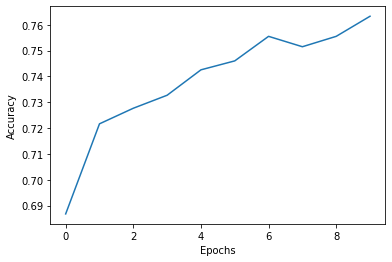

In [29]:
plt.plot(history.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

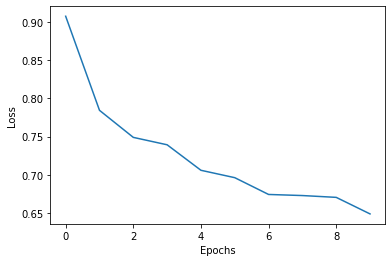

In [30]:
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [31]:
accuracy.append({'VGG':scoreVGG})
model_vgg.save('modelVGG.h5')

In [32]:
import json
with open('./accuracies.json','w') as f:
    json.dump(accuracy,f)

#GUI
---
GUI is produced by Mutahhar bin Muzaffar and is demonstrated in the video.